In [1]:
import random
from random import randrange
from time import time
import pandas as pd
import numpy as np

In [2]:
INFINITY = 65535                        #set a infinity number
def get_full_matrix(D):
    lengthD = len(D)                    #size of adjacency matrix
    p = list(range(lengthD))
    P = []
    for i in range(lengthD):
        P.append(p)
    P = np.array(P)

    for i in range(lengthD):
        for j in range(lengthD):
            for k in range(lengthD):
                if(D[i,j] > D[i,k]+D[j,k]):         #a smaller indirect path between two vertices replaces a larger direct path
                    P[i,j] = P[j,k]
                    D[i,j] = D[i,k]+D[j,k]
    return D, P

In [3]:
data = pd.read_excel("basicData.xlsx", header = None)

In [4]:
adj = data[31:]

In [5]:
adj.set_index(0, inplace=True)
adj.fillna(INFINITY, inplace=True)
adj_mat = adj.replace({
    '\\': 0,
    '/': INFINITY
}).values

C:\Users\adolph\anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [6]:
#D means distance P means previous
D, P = get_full_matrix(adj_mat)

In [7]:
need = []
for _, value in data.loc[3:27, 0:1].iterrows():
    need.append((tuple(value)))

In [8]:
need

[(1, 20),
 (2, 36),
 (3, 42),
 (4, 32),
 (5, 12),
 (6, 43),
 (7, 8),
 (8, 13),
 (9, 23),
 (10, 26),
 (11, 5),
 (12, 15),
 (13, 23),
 (14, 18),
 (15, 29),
 (16, 7),
 (17, 9),
 (18, 20),
 (19, 17),
 (20, 27),
 (21, 9),
 (22, 16),
 (23, 33),
 (24, 19),
 (25, 26)]

In [9]:
class Genetic(object):
    
    def __init__(self,genes,decode,fitness, cost):
        
        self.genes= genes
        
        # individual length
        self.individual_length= len(genes)
        
        # function of decode
        self.decode= decode
        
        # function of fitness
        self.fitness= fitness
        
        # function to calculate cost
        self.cost= cost


    # crossing over inheritance
    def crossover(self,parent1, parent2):
        
        # two generated chromosomes are illegal
        def fix_repeat(copy_child1,copy_child2):
            for index1, gen1 in enumerate(copy_child1[:pos]):
                repeat = copy_child1.count(gen1)
                # repetitions appeared, which means illegal
                if repeat > 1 :
                    # repetitions appeared, which means there are missings, let's seek the first missing
                    for index2, gen2 in enumerate(parent1[pos:]):
                        if gen2 not in copy_child1:
                            child1[index1] = parent1[pos:][index2]       
                            
            # the another chromosome has the same treatment
            for index1, gen1 in enumerate(copy_child2[:pos]):
                repeat = copy_child2.count(gen1)
                if repeat > 1:
                    for index2, gen2 in enumerate(parent2[pos:]):
                        if gen2 not in copy_child2:
                            child2[index1] = parent2[pos:][index2]
            return [child1,child2]
        
        # select random positions and perform crossover operations on chromosomes
        pos=random.randrange(1,self.individual_length-1)
        child1 = parent1[:pos] + parent2[pos:] 
        child2 = parent2[:pos] + parent1[pos:] 
        
        # some chromosomes are illegal
        return  fix_repeat(child1, child2)
    
    # reverse mutation regardless of legitimacy
    def mutation(self, chromosome, prob):
            
        def inversion(chromosome):
            chromo = chromosome
            
            # pick two locations randomly，index1 < index2
            index1 = randrange(0,len(chromo))
            index2 = randrange(index1,len(chromo))
            
            # reverse between two positions
            rev = chromo[index1: index2]
            rev.reverse()
                
            return chromo[0:index1] + rev+ chromo[index2:]
        
        aux = chromosome
        for _ in range(len(chromosome)):
            if random.random() < prob :
                aux = inversion(chromosome)
        return aux

In [10]:
# decode function, insert label（start，end，full）
def decode(chromosome):
    
    # record the number of times back to the starting point
    overloads = 0
    
    # record the current transportation volume of each truck (for judging whether it is necessary to return to the starting point)
    capacity_list = [0] * len(trucks)
    
    # record the total transportation volume of each truck (for adding to fitness to achieve load balancing)
    all_cap = [0] * len(trucks)
    
    # whenever a truck gene is encountered, it represents the route to another vehicle，index++
    truck_index = 0
    
    decode = [(start, 'start')]
    for (k,v) in chromosome:
        
        # met the truck gene
        if str(k).find('truck')!=-1:
            # index++
            truck_index += 1
            # reset back to starting point
            overloads = 0
            
            # represents the end of the route for the previous vehicle, and the start of the route for the next vehicle
            # so insert an end and start
            decode.append((start, 'end'))
            decode.append((k, v))
            decode.append((start, 'start'))
            continue
        # add transportation volume
        capacity_list[truck_index]+=v
        all_cap[truck_index] += v
        
        # if need to go back
        if capacity_list[truck_index] > capacity_trucks:
            
            # reset the current transportation volume
            capacity_list[truck_index] = v
            overloads+=1
            # add a full tag to represent going back
            decode.append((start, 'full'))
        decode.append((k, v))
    decode.append((start, 'end'))
    return decode, all_cap

In [11]:
capacity_trucks = 100
start = 1
chromo = [(2, 50), (3, 50), (4, 80), (5,30), ('truck', 100), (6, 50), (2, 50), (3, 80), (4,10), (5,10), (6,20)]
trucks = ['truck','truck','truck']
decode(chromo)

([(1, 'start'),
  (2, 50),
  (3, 50),
  (1, 'full'),
  (4, 80),
  (1, 'full'),
  (5, 30),
  (1, 'end'),
  ('truck', 100),
  (1, 'start'),
  (6, 50),
  (2, 50),
  (1, 'full'),
  (3, 80),
  (4, 10),
  (5, 10),
  (1, 'full'),
  (6, 20),
  (1, 'end')],
 [210, 220, 0])

In [12]:
def fitness2(chromosome):
    def distanceTrip(out_,in_):
        w = distances.get(out_)
        return  w[in_-1]
        
    fitness = 0
    
    # get the decoded list, and the total truck volume
    decode_chromo, all_cap = decode(chromosome)
    
    route_list = [[]]
    for index, value in enumerate(decode_chromo):
        
        # has a truck label to indicate that the previous car's route is over
        if str(value[0]).find('truck') != -1:
            
            # open up a new truck's route
            route_list.append([])
        else:
            
            # otherwise add the city to the current route
            route_list[-1].append(value)
    # all routes of all cars are obtained in a loop in the previous step
    # so the fitness can be calculated directly according to the route.
    for route in route_list:
        for index, (key, value) in enumerate(route[1: ]):
            out_ = route[index][0]
            in_ = key
            # according to the adjacency matrix, calculate the cost of out->in
            fitness+= distanceTrip(out_,in_)
            
    # the truck with the largest total transportation volume is added to the fitness to achieve load balance considerations
    fitness = 1 * fitness + 0.2 * max(all_cap)
    return fitness

In [13]:
def opt_chromo(chromosome):
    decode_chromo, _ = decode(chromosome)
    print(decode_chromo)
    decode_route = [[]]
    for (k, v) in decode_chromo:
        if v == 'full' or v == 'end':
            decode_route[-1].append(1)
            decode_route.append([])
        decode_route[-1].append(k)
    return decode_route

In [14]:
chromo = [(20, 27), (22, 16), (19, 17), (9, 23), (10, 26), (6, 43), ('truck2', 100), (15, 29), (18, 20),
          (23, 33), (11, 5), (21, 9), ('truck1', 100), (17, 9), (7, 8), (12, 15), (14, 18),
          (25, 26), (24, 19), (8, 13), (4, 32), (13, 23), (16, 7), (2, 36), (5, 12), (3, 42), (1, 20)]
opt_chromo(chromo)

[(1, 'start'), (20, 27), (22, 16), (19, 17), (9, 23), (1, 'full'), (10, 26), (6, 43), (1, 'end'), ('truck2', 100), (1, 'start'), (15, 29), (18, 20), (23, 33), (11, 5), (21, 9), (1, 'end'), ('truck1', 100), (1, 'start'), (17, 9), (7, 8), (12, 15), (14, 18), (25, 26), (24, 19), (1, 'full'), (8, 13), (4, 32), (13, 23), (16, 7), (1, 'full'), (2, 36), (5, 12), (3, 42), (1, 'full'), (1, 20), (1, 'end')]


[[1, 20, 22, 19, 9, 1],
 [1, 10, 6, 1],
 [1, 'truck2', 1, 15, 18, 23, 11, 21, 1],
 [1, 'truck1', 1, 17, 7, 12, 14, 25, 24, 1],
 [1, 8, 4, 13, 16, 1],
 [1, 2, 5, 3, 1],
 [1, 1, 1],
 [1]]

In [15]:
def cost(chromosome):
# calculate cost, similar to fitness1
    def distanceTrip(out_,in_):
        w = distances.get(out_)
        return  w[in_-1]
        
    cost = 0
    
    decode_chromo, _ = decode(chromosome)
    
    route_list = [[]]
    for index, value in enumerate(decode_chromo):
        if str(value[0]).find('truck') != -1:
            route_list.append([])
        else:
            route_list[-1].append(value)
    for route in route_list:
        for index, (key, value) in enumerate(route[1: ]):
            out_ = route[index][0]
            in_ = key
            cost+= distanceTrip(out_,in_)
    return cost

In [16]:
# calculate fitness
def fitness(chromosome):
# calculate fitness1, except for the consideration of load balancing, everything else is exactly the same as fitness2
    def distanceTrip(out_,in_):
        w = distances.get(out_)
        return  w[in_-1]
        
    fitness_value = 0
    
    decode_chromo, _ = decode(chromosome)
    
    route_list = [[]]
    for index, value in enumerate(decode_chromo):
        if str(value[0]).find('truck') != -1:
            route_list.append([])
        else:
            route_list[-1].append(value)
    for route in route_list:
        for index, (key, value) in enumerate(route[1: ]):
            out_ = route[index][0]
            in_ = key
            fitness_value+= distanceTrip(out_,in_)
    return fitness_value

In [17]:
def genetic_algorithm_t(Problem_Genetic,k,ngen,size,ratio_cross,prob_mutate):
    
    # initialize the population and randomly scramble the genes
    def initial_population(Problem_Genetic,size):   
        def generate_chromosome():
            chromosome=[i for i in Problem_Genetic.genes]
            random.shuffle(chromosome)
            return chromosome
        return [generate_chromosome() for _ in range(size)]
    
    # new generation
    def new_generation_t(Problem_Genetic,k,population,n_parents,n_directs,prob_mutate):  
        
        # Tournament selection，it is better to have a two-by-two comparison
        def tournament_selection(Problem_Genetic,population,n,k):
            winners=[]
            for _ in range(n):
                elements = random.sample(population,k)
                winners.append(min(elements,key=Problem_Genetic.fitness))
            return winners
        
        # crossover
        def cross_parents(Problem_Genetic,parents):
            childs=[]
            for i in range(0,len(parents),2):
                childs.extend(Problem_Genetic.crossover(parents[i],parents[i+1]))
            return childs
    
        def mutate(Problem_Genetic,population,prob):
            for index, chromo in enumerate(population):
                population[index] = Problem_Genetic.mutation(chromo, prob)
            return population
        
        # proportionate selection of individuals who go directly to the next generation
        directs = tournament_selection(Problem_Genetic, population, n_directs, k)
        
        # individuals that need to be crossed
        crosses = cross_parents(Problem_Genetic,
                                tournament_selection(Problem_Genetic, population, n_parents, k))
        mutations = mutate(Problem_Genetic, crosses, prob_mutate)
        
        # generate next parent
        new_generation = directs + mutations
        
        return new_generation
    
    population = initial_population(Problem_Genetic, size)
    n_parents = round(size*ratio_cross)
    n_parents = (n_parents if n_parents%2==0 else n_parents-1)
    n_directs = size - n_parents
    
    mean_fitness = []
    mean_cost = []
    best_fitness = []
    best_cost = []
    for _ in range(ngen):
        
        # generate a new generation
        population = new_generation_t(Problem_Genetic, k, population, n_parents, n_directs, prob_mutate)
        
        # average fitness per generation
        mean_fitness.append(sum([Problem_Genetic.fitness(p) for p in population])/len(population))
        
        # average cost per generation
        mean_cost.append(sum([Problem_Genetic.cost(p) for p in population])/len(population))
        
        # the best fitness for every generation
        best_fitness.append(Problem_Genetic.fitness(min(population, key = Problem_Genetic.fitness)))
        
        # best cost per generation
        best_cost.append(Problem_Genetic.cost(min(population, key = Problem_Genetic.cost)))
    
    bestChromosome = min(population, key = Problem_Genetic.fitness)
    print("Chromosome: ", bestChromosome)
    genotype = Problem_Genetic.decode(bestChromosome)
    print ("Solution: " , (genotype,Problem_Genetic.fitness(bestChromosome)))
    return (genotype,Problem_Genetic.fitness(bestChromosome), 
           mean_fitness, mean_cost, best_fitness, best_cost, genotype[0].count((1, 'full'))+num_trucks, genotype[1])

In [18]:
w1 = [999,453,317,165,508,222,223,410]
w2 = [453,999,252,292,210,325,235,121]
w3 = [317,252,999,201,235,116,158,141]
w4 = [165,292,201,999,346,93,125,248]
w5 = [508,210,235,346,999,340,302,93]
w6 = [222,325,116,93,340,999,185,242]
w7 = [223,235,158,125,302,185,999,199]
w8 = [410,121,141,248,93,242,199,999]
distances = {1:w1,2:w2,3:w3,4:w4,5:w5,6:w6,7:w7,8:w8}

In [19]:
# default some parameters, used to control variables
def execute_algorithm(k, need, fitness, nG = 200, nP = 100, pD=0.8, pM = 0.05):
    PROBLEM = Genetic(need + [(trucks[i],capacity_trucks) for i in range(len(trucks)-1)],
                                  lambda x : decode(x), fitness, lambda z: cost(z))
    
    def start_GA(k):
        cont  = 0
        print("num of trucks = ", len(trucks))
        print("Capacity of trucks = ",capacity_trucks)
        print("")
        stime = time()
        res = []
        while cont < k:
            genotype, fitness, mean_fitness, mean_cost, best_fitness, best_cost, cir, all_cap = genetic_algorithm_t(PROBLEM, 2, nG, nP, pD, pM)
            
            # get the information of each population, store it in dict, and return
            dict_res = {
                'mean_fitness': mean_fitness,
                'mean_cost': mean_cost,
                'best_fitness': best_fitness,
                'best_cost': best_cost,
                'cir' : cir,
                'all_cap': all_cap
            }
            print(cir)
            res.append(dict_res)
            cont+=1
        etime = time()
        print("\n") 
        print("Total time: ",(etime - stime)," secs.\n")
        return res
    res = start_GA(k)
    return res

In [20]:
capacity_trucks = 100
trucks = ['truck1','truck2','truck3']
num_trucks = len(trucks)

In [21]:
distances = {}
for index, value in enumerate(D.tolist()):
    distances[index+1] = value

In [22]:
instance_results = []
genetic_problem_instances = 10
res = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y))

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(9, 23), (14, 18), (12, 15), (16, 7), (13, 23), (5, 12), (21, 9), (11, 5), (7, 8), (19, 17), (25, 26), (24, 19), (17, 9), ('truck1', 100), (23, 33), (22, 16), (20, 27), (15, 29), (8, 13), (6, 43), (1, 20), ('truck2', 100), (10, 26), (18, 20), (2, 36), (4, 32), (3, 42)]
Solution:  (([(1, 'start'), (9, 23), (14, 18), (12, 15), (16, 7), (13, 23), (5, 12), (1, 'full'), (21, 9), (11, 5), (7, 8), (19, 17), (25, 26), (24, 19), (17, 9), (1, 'end'), ('truck1', 100), (1, 'start'), (23, 33), (22, 16), (20, 27), (1, 'full'), (15, 29), (8, 13), (6, 43), (1, 'full'), (1, 20), (1, 'end'), ('truck2', 100), (1, 'start'), (10, 26), (18, 20), (2, 36), (1, 'full'), (4, 32), (3, 42), (1, 'end')], [191, 181, 156]), 210)
7
Chromosome:  [(12, 15), (9, 23), (19, 17), (11, 5), (13, 23), (5, 12), (25, 26), (24, 19), (21, 9), (14, 18), (17, 9), (7, 8), (2, 36), (3, 42), (6, 43), (18, 20), (10, 26), (8, 13), (15, 29), (4, 32), ('truck2', 100), (23, 33), (

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as img

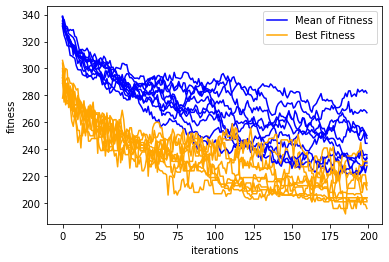

In [24]:
# Model Iteration
plt.plot(res[0]['mean_fitness'], color = 'blue',label = 'Mean of Fitness')
plt.plot(res[0]['best_fitness'], color = 'orange',label = 'Best Fitness')
for i in range(1, len(res)):
    plt.plot(res[i]['mean_fitness'], color = 'blue')
    plt.plot(res[i]['best_fitness'], color = 'orange')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('fitness')
plt.savefig("comp.png")
plt.show()

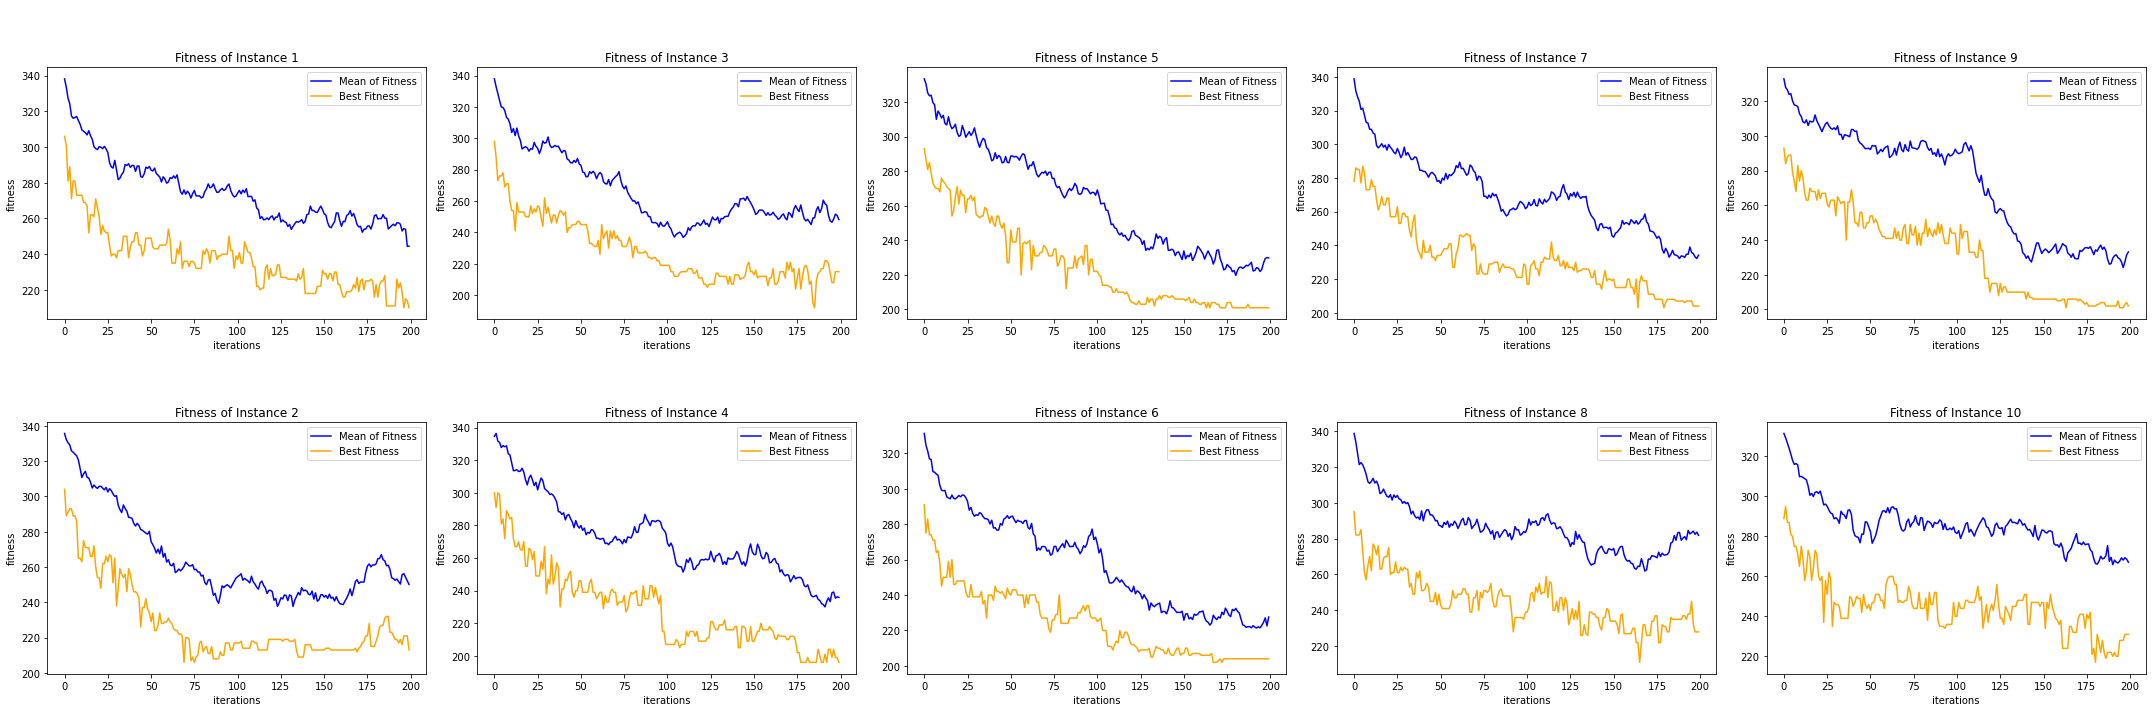

In [25]:
pl, ax = plt.subplots(2,5, figsize = (30, 10))
for i in range(len(res)):
    ax[i%2, i//2].plot(res[i]['mean_fitness'], color = 'blue',label = 'Mean of Fitness')
    ax[i%2, i//2].plot(res[i]['best_fitness'], color = 'orange',label = 'Best Fitness')
    #ax[i%5, i//5].axis('off')
    ax[i%2, i//2].legend()
    ax[i%2, i//2].set_xlabel('iterations')
    ax[i%2, i//2].set_ylabel('fitness')
    ax[i%2, i//2].set_title("\n\n\nFitness of Instance %d"%(i+1))
plt.tight_layout()
plt.savefig('all_res.png', dpi=200)
#plt.show()

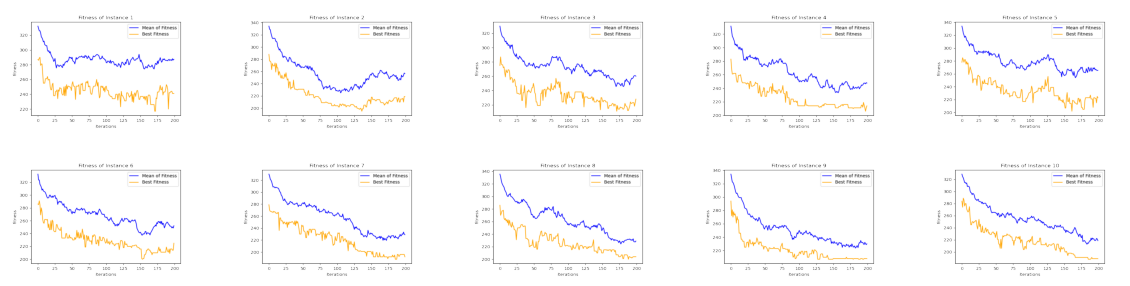

In [26]:
fig = plt.figure(figsize=(20,5))
for i in range(len(res)):
    ax = fig.add_subplot(2,5,i+1)
    im = img.imread(r"fig/%d.png"%(i+1))
    ax.imshow(im, aspect='auto')
    ax.axis('off')
    
plt.show()

In [27]:
# pointed fitness2
instance_results = []
genetic_problem_instances = 10
print("EXECUTING ", genetic_problem_instances, " INSTANCES ")
res2 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness2(y))

EXECUTING  10  INSTANCES 
num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(2, 36), (4, 32), (6, 43), (17, 9), (22, 16), (7, 8), (23, 33), (25, 26), (24, 19), ('truck1', 100), (20, 27), (16, 7), (13, 23), (3, 42), (18, 20), (10, 26), (15, 29), (8, 13), ('truck2', 100), (5, 12), (9, 23), (19, 17), (14, 18), (21, 9), (11, 5), (12, 15), (1, 20)]
Solution:  (([(1, 'start'), (2, 36), (4, 32), (1, 'full'), (6, 43), (17, 9), (22, 16), (7, 8), (1, 'full'), (23, 33), (25, 26), (24, 19), (1, 'end'), ('truck1', 100), (1, 'start'), (20, 27), (16, 7), (13, 23), (3, 42), (1, 'full'), (18, 20), (10, 26), (15, 29), (8, 13), (1, 'end'), ('truck2', 100), (1, 'start'), (5, 12), (9, 23), (19, 17), (14, 18), (21, 9), (11, 5), (12, 15), (1, 'full'), (1, 20), (1, 'end')], [222, 187, 119]), 253.4)
7
Chromosome:  [(20, 27), (16, 7), (14, 18), (7, 8), (4, 32), (8, 13), (17, 9), (22, 16), (23, 33), (25, 26), ('truck2', 100), (2, 36), (3, 42), (6, 43), (18, 20), (10, 26), (1, 20), ('truck1', 100), (24,

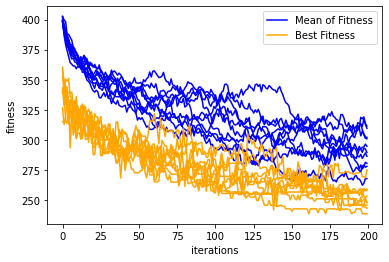

In [28]:
plt.plot(res2[0]['mean_fitness'], color = 'blue',label = 'Mean of Fitness')
plt.plot(res2[0]['best_fitness'], color = 'orange',label = 'Best Fitness')
for i in range(1, len(res2)):
    plt.plot(res2[i]['mean_fitness'], color = 'blue')
    plt.plot(res2[i]['best_fitness'], color = 'orange')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('fitness')
plt.savefig("fiteness2_comp.png")
plt.show()

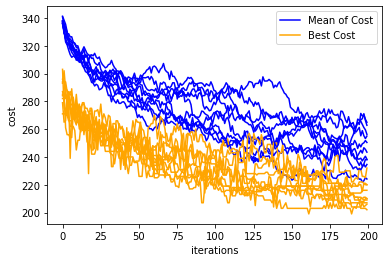

In [29]:
plt.plot(res2[0]['mean_cost'], color = 'blue',label = 'Mean of Cost')
plt.plot(res2[0]['best_cost'], color = 'orange',label = 'Best Cost')
for i in range(1, len(res2)):
    plt.plot(res2[i]['mean_cost'], color = 'blue')
    plt.plot(res2[i]['best_cost'], color = 'orange')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('cost')
plt.savefig("cost2_comp.png")
plt.show()

### Comparison of fitness1 and fitness2

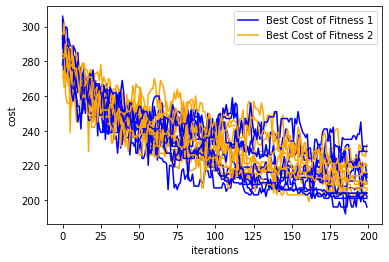

In [30]:
plt.plot(res[0]['best_cost'][:200], color = 'blue',label = 'Best Cost of Fitness 1')
plt.plot(res2[0]['best_cost'][:200], color = 'orange',label = 'Best Cost of Fitness 2')
for i in range(1, len(res2)):
    plt.plot(res[i]['best_cost'][:200], color = 'blue')
    plt.plot(res2[i]['best_cost'][:200], color = 'orange')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('cost')
plt.savefig("cost_by_fitness.png")
plt.show()

In [31]:
res[2]['cir']

9

In [32]:
cirr1 = []
cirr2 = []
for i in range(len(res)):
    cirr1.append(res[i]['cir'])
    cirr2.append(res2[i]['cir'])

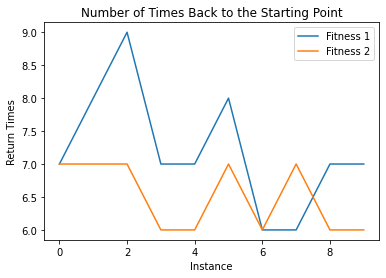

In [33]:
plt.title("Number of Times Back to the Starting Point")
plt.plot(cirr1, label = "Fitness 1")
plt.plot(cirr2, label = "Fitness 2")
plt.xlabel("Instance")
plt.ylabel("Return Times")
plt.legend()
plt.show()

In [34]:
max_cap1 = []
max_cap2 = []
min_cap1 = []
min_cap2 = []
std_cap1 = []
std_cap2 = []
for i in range(len(res)):
    max_cap1.append(max(res[i]['all_cap']))
    max_cap2.append(max(res2[i]['all_cap']))
    min_cap1.append(min(res[i]['all_cap']))
    min_cap2.append(min(res2[i]['all_cap']))
    std_cap1.append(np.std(res[i]['all_cap']))
    std_cap2.append(np.std(res2[i]['all_cap']))
    

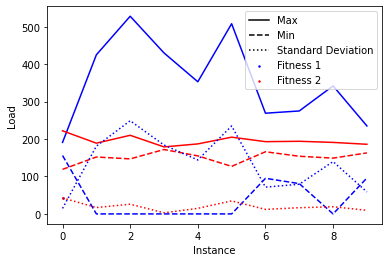

In [35]:
plt.plot(max_cap1, color='blue')
plt.plot(max_cap2, color='red')
plt.plot(min_cap1, color='blue',linestyle = '--')
plt.plot(min_cap2, color='red', linestyle = '--')
plt.plot(std_cap1, color='blue', linestyle = ':')
plt.plot(std_cap2, color='red', linestyle = ':')
plt.scatter(0,std_cap2[0], label = 'Fitness 1', color='blue', s=2)
plt.scatter(0,std_cap2[0], label = 'Fitness 2', color='red', s=2)
plt.plot(std_cap2[0], label = 'Max', color='black')
plt.plot(std_cap2[0], label = 'Min', linestyle='--', color='black')
plt.plot(std_cap2[0], label = 'Standard Deviation', linestyle=':', color='black')
plt.xlabel('Instance')
plt.ylabel('Load')
plt.legend()

### Control variates

In [36]:
# np = 100
np100 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nP=100)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(3, 42), (10, 26), (4, 32), (15, 29), (5, 12), (21, 9), (11, 5), (24, 19), (19, 17), ('truck2', 100), (18, 20), (14, 18), (12, 15), (9, 23), (22, 16), (7, 8), (17, 9), (23, 33), (25, 26), (2, 36), (6, 43), (1, 20), ('truck1', 100), (13, 23), (16, 7), (20, 27), (8, 13)]
Solution:  (([(1, 'start'), (3, 42), (10, 26), (4, 32), (1, 'full'), (15, 29), (5, 12), (21, 9), (11, 5), (24, 19), (19, 17), (1, 'end'), ('truck2', 100), (1, 'start'), (18, 20), (14, 18), (12, 15), (9, 23), (22, 16), (7, 8), (1, 'full'), (17, 9), (23, 33), (25, 26), (1, 'full'), (2, 36), (6, 43), (1, 20), (1, 'end'), ('truck1', 100), (1, 'start'), (13, 23), (16, 7), (20, 27), (8, 13), (1, 'end')], [191, 267, 70]), 215)
6
Chromosome:  [(10, 26), (6, 43), (15, 29), (2, 36), (8, 13), (7, 8), (20, 27), (23, 33), (17, 9), (21, 9), (25, 26), (24, 19), (4, 32), (11, 5), (5, 12), (13, 23), (16, 7), (22, 16), (12, 15), (19, 17), (9, 23), (14, 18), (18, 20), ('truck2', 1

In [37]:
# np = 200
np200 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nP=200)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(18, 20), (14, 18), (21, 9), (11, 5), (12, 15), (9, 23), (19, 17), (24, 19), (25, 26), (22, 16), (17, 9), (7, 8), (15, 29), (8, 13), (4, 32), ('truck1', 100), (10, 26), (6, 43), ('truck2', 100), (2, 36), (3, 42), (5, 12), (23, 33), (20, 27), (16, 7), (13, 23), (1, 20)]
Solution:  (([(1, 'start'), (18, 20), (14, 18), (21, 9), (11, 5), (12, 15), (9, 23), (1, 'full'), (19, 17), (24, 19), (25, 26), (22, 16), (17, 9), (7, 8), (1, 'full'), (15, 29), (8, 13), (4, 32), (1, 'end'), ('truck1', 100), (1, 'start'), (10, 26), (6, 43), (1, 'end'), ('truck2', 100), (1, 'start'), (2, 36), (3, 42), (5, 12), (1, 'full'), (23, 33), (20, 27), (16, 7), (13, 23), (1, 'full'), (1, 20), (1, 'end')], [259, 69, 200]), 200)
7
Chromosome:  [('truck1', 100), (2, 36), (17, 9), (22, 16), (16, 7), (20, 27), (21, 9), (14, 18), (7, 8), (11, 5), (9, 23), (12, 15), (18, 20), (8, 13), (4, 32), (3, 42), ('truck2', 100), (13, 23), (5, 12), (19, 17), (24, 19), (25, 

In [38]:
# np = 300
np300 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nP=300)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(15, 29), (8, 13), (7, 8), (24, 19), (10, 26), (6, 43), (4, 32), (2, 36), (3, 42), (25, 26), (19, 17), (11, 5), (23, 33), (17, 9), ('truck2', 100), (1, 20), ('truck1', 100), (18, 20), (21, 9), (14, 18), (12, 15), (9, 23), (5, 12), (13, 23), (16, 7), (20, 27), (22, 16)]
Solution:  (([(1, 'start'), (15, 29), (8, 13), (7, 8), (24, 19), (10, 26), (1, 'full'), (6, 43), (4, 32), (1, 'full'), (2, 36), (3, 42), (1, 'full'), (25, 26), (19, 17), (11, 5), (23, 33), (17, 9), (1, 'end'), ('truck2', 100), (1, 'start'), (1, 20), (1, 'end'), ('truck1', 100), (1, 'start'), (18, 20), (21, 9), (14, 18), (12, 15), (9, 23), (5, 12), (1, 'full'), (13, 23), (16, 7), (20, 27), (22, 16), (1, 'end')], [338, 20, 170]), 213)
7
Chromosome:  [(1, 20), (2, 36), (4, 32), (3, 42), ('truck1', 100), (15, 29), (8, 13), (20, 27), (22, 16), ('truck2', 100), (10, 26), (25, 26), (23, 33), (17, 9), (21, 9), (18, 20), (14, 18), (12, 15), (9, 23), (11, 5), (7, 8), (5, 

In [39]:
# ng = 200
ng200 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nG=200)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [('truck1', 100), (20, 27), (16, 7), (13, 23), (15, 29), (1, 20), (8, 13), (23, 33), (22, 16), ('truck2', 100), (5, 12), (3, 42), (17, 9), (7, 8), (11, 5), (21, 9), (10, 26), (6, 43), (4, 32), (9, 23), (12, 15), (18, 20), (14, 18), (25, 26), (19, 17), (24, 19), (2, 36)]
Solution:  (([(1, 'start'), (1, 'end'), ('truck1', 100), (1, 'start'), (20, 27), (16, 7), (13, 23), (15, 29), (1, 'full'), (1, 20), (8, 13), (23, 33), (22, 16), (1, 'end'), ('truck2', 100), (1, 'start'), (5, 12), (3, 42), (17, 9), (7, 8), (11, 5), (21, 9), (1, 'full'), (10, 26), (6, 43), (1, 'full'), (4, 32), (9, 23), (12, 15), (18, 20), (1, 'full'), (14, 18), (25, 26), (19, 17), (24, 19), (1, 'full'), (2, 36), (1, 'end')], [0, 168, 360]), 240)
8
Chromosome:  [(2, 36), (4, 32), (8, 13), (10, 26), (6, 43), (24, 19), ('truck2', 100), (15, 29), (21, 9), (22, 16), (16, 7), (20, 27), (23, 33), (25, 26), (19, 17), (11, 5), (7, 8), (13, 23), (5, 12), (3, 42), ('truck1'

In [40]:
# ng = 300
ng300 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nG=300)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(4, 32), (10, 26), (18, 20), (1, 20), (11, 5), (5, 12), (21, 9), (14, 18), (12, 15), (15, 29), (19, 17), (24, 19), (25, 26), (22, 16), (7, 8), (17, 9), (23, 33), ('truck1', 100), (20, 27), (16, 7), (13, 23), (8, 13), ('truck2', 100), (3, 42), (9, 23), (6, 43), (2, 36)]
Solution:  (([(1, 'start'), (4, 32), (10, 26), (18, 20), (1, 20), (1, 'full'), (11, 5), (5, 12), (21, 9), (14, 18), (12, 15), (15, 29), (1, 'full'), (19, 17), (24, 19), (25, 26), (22, 16), (7, 8), (17, 9), (1, 'full'), (23, 33), (1, 'end'), ('truck1', 100), (1, 'start'), (20, 27), (16, 7), (13, 23), (8, 13), (1, 'end'), ('truck2', 100), (1, 'start'), (3, 42), (9, 23), (1, 'full'), (6, 43), (2, 36), (1, 'end')], [314, 70, 144]), 240)
7
Chromosome:  [(24, 19), (25, 26), (23, 33), (22, 16), (1, 20), (10, 26), (21, 9), (6, 43), (15, 29), (4, 32), ('truck1', 100), ('truck2', 100), (8, 13), (20, 27), (16, 7), (13, 23), (19, 17), (5, 12), (9, 23), (11, 5), (7, 8), (17,

In [41]:
# ng = 500
ng500 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nG=500)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(4, 32), (3, 42), (2, 36), (8, 13), (15, 29), (6, 43), (24, 19), (10, 26), (18, 20), (21, 9), (14, 18), (12, 15), (9, 23), (11, 5), (7, 8), (19, 17), (25, 26), (23, 33), ('truck2', 100), (17, 9), (22, 16), (20, 27), (16, 7), (13, 23), (5, 12), (1, 20), ('truck1', 100)]
Solution:  (([(1, 'start'), (4, 32), (3, 42), (1, 'full'), (2, 36), (8, 13), (15, 29), (1, 'full'), (6, 43), (24, 19), (10, 26), (1, 'full'), (18, 20), (21, 9), (14, 18), (12, 15), (9, 23), (11, 5), (7, 8), (1, 'full'), (19, 17), (25, 26), (23, 33), (1, 'end'), ('truck2', 100), (1, 'start'), (17, 9), (22, 16), (20, 27), (16, 7), (13, 23), (5, 12), (1, 'full'), (1, 20), (1, 'end'), ('truck1', 100), (1, 'start'), (1, 'end')], [414, 114, 0]), 193)
8
Chromosome:  [(4, 32), (15, 29), (8, 13), (2, 36), (3, 42), ('truck1', 100), (13, 23), (11, 5), (21, 9), (25, 26), (24, 19), (18, 20), (10, 26), (6, 43), ('truck2', 100), (5, 12), (9, 23), (19, 17), (12, 15), (14, 18), 

In [42]:
# pDirect = 60%
pd6 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), pD=0.6)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(1, 20), (10, 26), (6, 43), (25, 26), (21, 9), (18, 20), (14, 18), (12, 15), (17, 9), (24, 19), (19, 17), (9, 23), (11, 5), (5, 12), ('truck1', 100), ('truck2', 100), (3, 42), (13, 23), (16, 7), (20, 27), (7, 8), (22, 16), (23, 33), (15, 29), (8, 13), (4, 32), (2, 36)]
Solution:  (([(1, 'start'), (1, 20), (10, 26), (6, 43), (1, 'full'), (25, 26), (21, 9), (18, 20), (14, 18), (12, 15), (17, 9), (1, 'full'), (24, 19), (19, 17), (9, 23), (11, 5), (5, 12), (1, 'end'), ('truck1', 100), (1, 'start'), (1, 'end'), ('truck2', 100), (1, 'start'), (3, 42), (13, 23), (16, 7), (20, 27), (1, 'full'), (7, 8), (22, 16), (23, 33), (15, 29), (8, 13), (1, 'full'), (4, 32), (2, 36), (1, 'end')], [262, 0, 266]), 197)
7
Chromosome:  [(21, 9), (18, 20), (14, 18), (9, 23), (15, 29), (7, 8), (12, 15), (19, 17), (16, 7), (13, 23), (5, 12), (11, 5), ('truck1', 100), (6, 43), (4, 32), ('truck2', 100), (17, 9), (22, 16), (23, 33), (8, 13), (1, 20), (2, 36

In [43]:
# pDirect = 80%
pd8 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), pD=0.8)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(11, 5), (5, 12), (13, 23), (16, 7), (20, 27), (22, 16), (7, 8), (17, 9), (24, 19), (25, 26), (23, 33), (15, 29), (8, 13), (2, 36), (10, 26), (18, 20), (6, 43), ('truck1', 100), (3, 42), (4, 32), ('truck2', 100), (21, 9), (14, 18), (12, 15), (9, 23), (19, 17), (1, 20)]
Solution:  (([(1, 'start'), (11, 5), (5, 12), (13, 23), (16, 7), (20, 27), (22, 16), (7, 8), (1, 'full'), (17, 9), (24, 19), (25, 26), (23, 33), (1, 'full'), (15, 29), (8, 13), (2, 36), (1, 'full'), (10, 26), (18, 20), (6, 43), (1, 'end'), ('truck1', 100), (1, 'start'), (3, 42), (4, 32), (1, 'end'), ('truck2', 100), (1, 'start'), (21, 9), (14, 18), (12, 15), (9, 23), (19, 17), (1, 'full'), (1, 20), (1, 'end')], [352, 74, 102]), 191)
7
Chromosome:  [(15, 29), (10, 26), (6, 43), (4, 32), (8, 13), (21, 9), (14, 18), (18, 20), (7, 8), (12, 15), (9, 23), (3, 42), ('truck1', 100), (17, 9), (24, 19), (25, 26), (2, 36), (1, 20), ('truck2', 100), (20, 27), (16, 7), (13, 

In [44]:
# pDirect = 90%
pd9 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), pD=0.9)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(12, 15), (14, 18), (18, 20), (8, 13), (15, 29), (3, 42), (4, 32), (10, 26), (2, 36), ('truck1', 100), (5, 12), (11, 5), (21, 9), (25, 26), (6, 43), (24, 19), (7, 8), (23, 33), (9, 23), (19, 17), ('truck2', 100), (13, 23), (16, 7), (20, 27), (22, 16), (17, 9), (1, 20)]
Solution:  (([(1, 'start'), (12, 15), (14, 18), (18, 20), (8, 13), (15, 29), (1, 'full'), (3, 42), (4, 32), (10, 26), (1, 'full'), (2, 36), (1, 'end'), ('truck1', 100), (1, 'start'), (5, 12), (11, 5), (21, 9), (25, 26), (6, 43), (1, 'full'), (24, 19), (7, 8), (23, 33), (9, 23), (19, 17), (1, 'end'), ('truck2', 100), (1, 'start'), (13, 23), (16, 7), (20, 27), (22, 16), (17, 9), (1, 'full'), (1, 20), (1, 'end')], [231, 195, 102]), 222)
7
Chromosome:  [(7, 8), (22, 16), (10, 26), (4, 32), (2, 36), (21, 9), (6, 43), (1, 20), (3, 42), ('truck2', 100), (24, 19), (18, 20), (25, 26), (23, 33), (11, 5), (9, 23), (19, 17), (12, 15), (17, 9), (14, 18), (8, 13), ('truck1', 

In [45]:
# pMutation = 2%
pm2 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), pM=0.02)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(15, 29), (8, 13), (17, 9), (7, 8), (2, 36), (24, 19), (19, 17), (12, 15), (9, 23), (3, 42), (4, 32), ('truck2', 100), (18, 20), (14, 18), (23, 33), (25, 26), (5, 12), (13, 23), (16, 7), (20, 27), (22, 16), (11, 5), (21, 9), (10, 26), (6, 43), (1, 20), ('truck1', 100)]
Solution:  (([(1, 'start'), (15, 29), (8, 13), (17, 9), (7, 8), (2, 36), (1, 'full'), (24, 19), (19, 17), (12, 15), (9, 23), (1, 'full'), (3, 42), (4, 32), (1, 'end'), ('truck2', 100), (1, 'start'), (18, 20), (14, 18), (23, 33), (25, 26), (1, 'full'), (5, 12), (13, 23), (16, 7), (20, 27), (22, 16), (11, 5), (21, 9), (1, 'full'), (10, 26), (6, 43), (1, 20), (1, 'end'), ('truck1', 100), (1, 'start'), (1, 'end')], [243, 285, 0]), 208)
7
Chromosome:  [(8, 13), (15, 29), (3, 42), (1, 20), (2, 36), (19, 17), (24, 19), (22, 16), (17, 9), (7, 8), (11, 5), (13, 23), (16, 7), (20, 27), (10, 26), (23, 33), (25, 26), (21, 9), ('truck1', 100), (18, 20), (14, 18), (12, 15), (

In [46]:
# pMutation = 5%
pm5 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), pM=0.05)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(18, 20), (14, 18), (9, 23), (19, 17), (17, 9), (7, 8), (15, 29), (16, 7), (13, 23), (5, 12), (11, 5), (12, 15), (21, 9), (23, 33), (22, 16), (20, 27), (8, 13), (24, 19), (25, 26), (10, 26), (1, 20), (6, 43), (4, 32), (2, 36), (3, 42), ('truck2', 100), ('truck1', 100)]
Solution:  (([(1, 'start'), (18, 20), (14, 18), (9, 23), (19, 17), (17, 9), (7, 8), (1, 'full'), (15, 29), (16, 7), (13, 23), (5, 12), (11, 5), (12, 15), (21, 9), (1, 'full'), (23, 33), (22, 16), (20, 27), (8, 13), (1, 'full'), (24, 19), (25, 26), (10, 26), (1, 20), (1, 'full'), (6, 43), (4, 32), (1, 'full'), (2, 36), (3, 42), (1, 'end'), ('truck2', 100), (1, 'start'), (1, 'end'), ('truck1', 100), (1, 'start'), (1, 'end')], [528, 0, 0]), 206)
8
Chromosome:  [(8, 13), (7, 8), (4, 32), (3, 42), (14, 18), (21, 9), (5, 12), (12, 15), (9, 23), (17, 9), (2, 36), (18, 20), (6, 43), (11, 5), (13, 23), (16, 7), (20, 27), (22, 16), ('truck1', 100), ('truck2', 100), (23, 3

In [47]:
# pMutation = 20%
pm20 = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), pM=0.2)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(12, 15), (9, 23), (14, 18), (21, 9), (5, 12), (13, 23), (18, 20), (23, 33), (10, 26), ('truck1', 100), (6, 43), (4, 32), (15, 29), ('truck2', 100), (7, 8), (22, 16), (20, 27), (16, 7), (11, 5), (17, 9), (19, 17), (24, 19), (25, 26), (8, 13), (3, 42), (2, 36), (1, 20)]
Solution:  (([(1, 'start'), (12, 15), (9, 23), (14, 18), (21, 9), (5, 12), (13, 23), (1, 'full'), (18, 20), (23, 33), (10, 26), (1, 'end'), ('truck1', 100), (1, 'start'), (6, 43), (4, 32), (1, 'full'), (15, 29), (1, 'end'), ('truck2', 100), (1, 'start'), (7, 8), (22, 16), (20, 27), (16, 7), (11, 5), (17, 9), (19, 17), (1, 'full'), (24, 19), (25, 26), (8, 13), (3, 42), (1, 'full'), (2, 36), (1, 20), (1, 'end')], [179, 104, 245]), 234)
7
Chromosome:  [(9, 23), (7, 8), (17, 9), (22, 16), (20, 27), (16, 7), (6, 43), ('truck2', 100), (18, 20), (3, 42), (2, 36), (4, 32), (10, 26), ('truck1', 100), (1, 20), (5, 12), (13, 23), (8, 13), (19, 17), (14, 18), (12, 15), (21,

In [48]:
'''
    This function compares different sets of control variables,
    comp_list: list of res dict, results of different groups
    para: list of str, description of different groups
'''
def comp_res(comp_list, para):
    
    # main color, the average of all populations (instants) in different groups
    colors = ['red', 'blue', 'yellow']
    # use the light version of the main color to highlight the main color, all population
    colors_sub = ['lightcoral', 'lightblue','lightyellow']
    bmean = []
    res_dict = {
        'Max Best Fitness': [],
        'Min Best Fitness': [],
        'Mean Best Fitness':[],
        'Max Poplution Fitness':[],
        'Min Poplution Fitness':[],
        'Mean Poplution Fitness':[],
    }
    for idx, res in enumerate(comp_list):
        cur_bestcost = []
        cur_meancost = []
        for i in range(1, len(res)):
            # save the best sum of each generation of each population into a list
            cur_bestcost.append(res[i]['best_cost'])
            cur_meancost.append(res[i]['mean_cost'])
        cur_bestcost = np.array(cur_bestcost)
        cur_meancost = np.array(cur_meancost)
        # draw the best
        for bc in cur_bestcost:
            plt.plot(bc, color = colors_sub[idx])
        # best average
        bmean.append(np.mean(cur_bestcost, axis = 0))
        
        # use the last generation of comparisons for within-group comparisons
        res_dict['Max Best Fitness'].append(np.max(cur_bestcost[:,-1]))
        res_dict['Min Best Fitness'].append(np.min(cur_bestcost[:,-1]))
        res_dict['Mean Best Fitness'].append(np.mean(cur_bestcost[:,-1]))
        res_dict['Max Poplution Fitness'].append(np.max(cur_meancost[:,-1]))
        res_dict['Min Poplution Fitness'].append(np.min(cur_meancost[:,-1]))
        res_dict['Mean Poplution Fitness'].append(np.mean(cur_meancost[:,-1]))
    for idx, bm in enumerate(bmean):
        plt.plot(bm, color = colors[idx],label = 'Best Fitness of '+para[idx])
    plt.legend()
    plt.xlabel('iterations')
    plt.ylabel('fitness')
    plt.savefig("fitness_by_%s.png"%(para[0].split()[0]))
    plt.show()
    
    # output related information
    print('Variable:', para[0].split()[0], end = '\t\t')
    for p in para:
        print(p.split()[-1], end = '\t')
    print()
    for k, value in res_dict.items():
        print(k, end = '\t\t')
        for v in value:
            print(round(v,1), end = '\t')
        print()

In [ ]:
colors = ['red', 'blue', 'yellow']
colors_sub = ['lightcoral', 'lightblue','lightyellow']
for bc in cur_bestcost:
    plt.plot(bc, color = colors_sub[idx])
for idx, bm in enumerate(bmean):
    plt.plot(bm, color = colors[idx],label = 'Best Fitness of '+para[idx])
plt.legend()
plt.xlabel('iterations')
plt.ylabel('fitness')
plt.savefig("fitness_by_%s.png"%(para[0].split()[0]))
plt.show()

In [ ]:
comp_res([np100, np200, np300], ['nP = 100','nP = 200','nP = 300'])

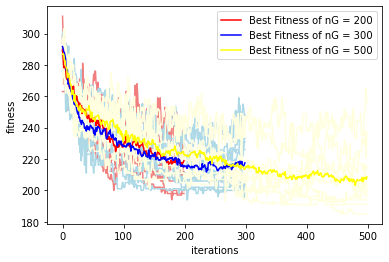

Variable: nG			200	300	500	
Max Best Fitness		239	248	256	
Min Best Fitness		198	200	185	
Mean Best Fitness		218.9	217.6	208.6	
Max Poplution Fitness		277.1	294.1	295.9	
Min Poplution Fitness		223.7	222.8	216.7	
Mean Poplution Fitness		251.6	252.4	240.1	


In [159]:
comp_res([ng200, ng300, ng500], ['nG = 200','nG = 300','nG = 500'])

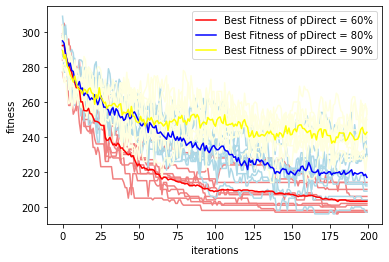

Variable: pDirect		60%	80%	90%	
Max Best Fitness		214	230	256	
Min Best Fitness		197	197	228	
Mean Best Fitness		203.2	216.9	242.7	
Max Poplution Fitness		229.4	280.5	302.8	
Min Poplution Fitness		208.6	223.4	265.8	
Mean Poplution Fitness		218.2	250.9	286.9	


In [163]:
comp_res([pd6, pd8, pd9], ['pDirect = 60%','pDirect = 80%','pDirect = 90%'])

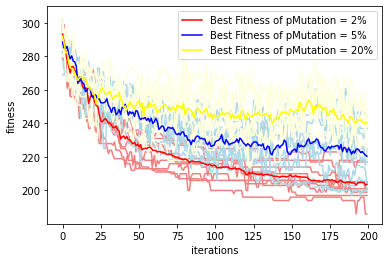

Variable: pMutation		2%	5%	20%	
Max Best Fitness		218	244	258	
Min Best Fitness		186	200	218	
Mean Best Fitness		203.7	220.4	240.6	
Max Poplution Fitness		230.2	294.0	303.8	
Min Poplution Fitness		204.5	214.8	271.2	
Mean Poplution Fitness		214.5	257.2	288.3	


In [164]:
comp_res([pm2, pm5, pm20], ['pMutation = 2%','pMutation = 5%','pMutation = 20%'])

In [4]:
rnd = np.random
rnd.seed(0)

In [5]:
# Number of cities
n = 200
# Random horizontal coordinates
xc = rnd.rand(n) * 100
# Random vertical coordinates
yc = rnd.rand(n) * 100

# All cities and city tuples
N = [i for i in range(1, n+1)]

A = [(i, j) for i in N for j in N if i!=j]

# Calculating the Euclidean distance between cities
def g_distance(cityi, cityj):
    return np.sqrt((xc[cityi]-xc[cityj])**2+(yc[cityi]-yc[cityj])**2)

distances = {}
# Adjacency matrix
for c1 in N:
    dis = []
    for c2 in N:
        dis.append(g_distance(c1-1, c2-1))
    distances[c1] = dis

Text(0.5, 1.0, 'Distribution of Random Horizontal Coordinates')

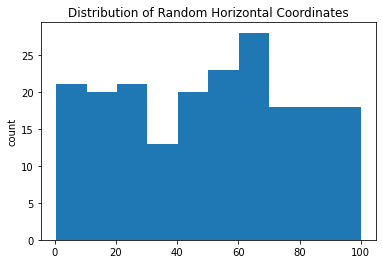

In [10]:
plt.hist(xc,bins=10)
plt.ylabel('count')
plt.title('Distribution of Random Horizontal Coordinates')

Text(0.5, 1.0, 'Distribution of Random Vertical Coordinates')

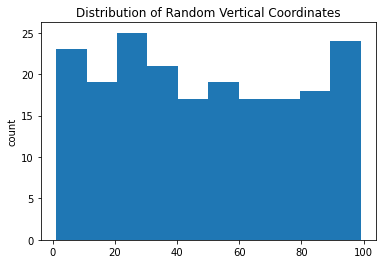

In [11]:
plt.hist(yc,bins=10)
plt.ylabel('count')
plt.title('Distribution of Random Vertical Coordinates')

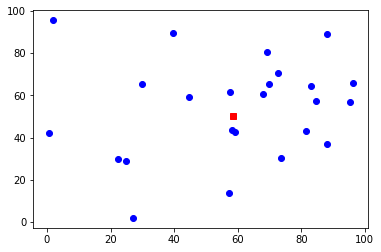

In [201]:
plt.plot(xc[0], yc[0], c = 'r', marker = 's')
plt.scatter(xc[1:], yc[1:],c = 'b')

In [203]:
def g_distance(cityi, cityj):
    return np.sqrt((xc[cityi]-xc[cityj])**2+(yc[cityi]-yc[cityj])**2)

In [205]:
distances = {}

In [206]:
for c1 in N:
    dis = []
    for c2 in N:
        dis.append(g_distance(c1-1, c2-1))
    distances[c1] = dis

In [207]:
distances

{1: [0.0,
  72.63752764685466,
  28.129065311430224,
  58.69523428394606,
  13.919700871704565,
  57.673726162356196,
  24.90099486824871,
  40.78789261580323,
  39.83803163314805,
  11.714964330409252,
  7.276604046175306,
  36.61281632338448,
  41.63032403061381,
  37.2612917210495,
  16.56737850729773,
  26.995355346035,
  18.928245160625636,
  32.6035577182386,
  23.77924730843956,
  43.85240382658671,
  32.353644651993356,
  6.566885652996372,
  48.96160120016114,
  32.277768294895324,
  24.55227414934147],
 2: [72.63752764685466,
  0.0,
  86.6955764778373,
  53.24516877922081,
  74.48922785099067,
  96.96462825489134,
  96.93969573754373,
  98.74610848979464,
  70.41610880067665,
  65.07545456719554,
  77.79267190594067,
  98.90720201478207,
  68.8404707702753,
  100.9409615514082,
  56.18925264832585,
  91.02269038445597,
  74.3830589504295,
  41.1479842555556,
  95.14293571345789,
  38.10777610155037,
  104.29148471500596,
  76.5201953263077,
  86.40133298878298,
  68.892742773

In [208]:
best_alg = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nG=500, nP = 300, pD = 0.6, pM=0.02)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(22, 16), (11, 5), (12, 15), (6, 43), (9, 23), (13, 23), (4, 32), (18, 20), (7, 8), (21, 9), (14, 18), (8, 13), (23, 33), (24, 19), (20, 27), (2, 36), (15, 29), (3, 42), (16, 7), (19, 17), ('truck', 100), (10, 26), (25, 26), (17, 9), (5, 12), ('truck', 100), (1, 20)]
Solution:  (([(1, 'start'), (22, 16), (11, 5), (12, 15), (6, 43), (1, 'full'), (9, 23), (13, 23), (4, 32), (18, 20), (1, 'full'), (7, 8), (21, 9), (14, 18), (8, 13), (23, 33), (24, 19), (1, 'full'), (20, 27), (2, 36), (15, 29), (1, 'full'), (3, 42), (16, 7), (19, 17), (1, 'end'), ('truck', 100), (1, 'start'), (10, 26), (25, 26), (17, 9), (5, 12), (1, 'end'), ('truck', 100), (1, 'start'), (1, 20), (1, 'end')], [435, 73, 20]), 695.9466615117624)
7
Chromosome:  [(15, 29), (10, 26), (25, 26), (17, 9), (19, 17), (21, 9), (7, 8), (12, 15), (6, 43), (11, 5), (4, 32), (13, 23), (9, 23), (22, 16), (20, 27), (2, 36), (18, 20), (1, 20), (3, 42), (5, 12), ('truck', 100), (24,

In [209]:
best_solution = (([(1, 'start'), (18, 20), (4, 32), (13, 23), (9, 23), (1, 'full'), (15, 29), (2, 36), (20, 27), (1, 'full'), (22, 16), (6, 43), (12, 15), (7, 8), (19, 17), (1, 'full'), (5, 12), (17, 9), (25, 26), (3, 42), (16, 7), (1, 'full'), (11, 5), (21, 9), (14, 18), (8, 13), (23, 33), (24, 19), (1, 'end'), ('truck', 100), (1, 'start'), (10, 26), (1, 'end'), ('truck', 100), (1, 'start'), (1, 20), (1, 'end')], [482, 26, 20]), 684.6436872966578)

In [212]:
route = best_solution[0][0]

In [214]:
route

[(1, 'start'),
 (18, 20),
 (4, 32),
 (13, 23),
 (9, 23),
 (1, 'full'),
 (15, 29),
 (2, 36),
 (20, 27),
 (1, 'full'),
 (22, 16),
 (6, 43),
 (12, 15),
 (7, 8),
 (19, 17),
 (1, 'full'),
 (5, 12),
 (17, 9),
 (25, 26),
 (3, 42),
 (16, 7),
 (1, 'full'),
 (11, 5),
 (21, 9),
 (14, 18),
 (8, 13),
 (23, 33),
 (24, 19),
 (1, 'end'),
 ('truck', 100),
 (1, 'start'),
 (10, 26),
 (1, 'end'),
 ('truck', 100),
 (1, 'start'),
 (1, 20),
 (1, 'end')]

In [241]:
route_city = [[]]

In [242]:
for r in route:
    if r[1] == 'full' or r[1] == 'end':
        route_city[-1].append(1)
        route_city.append([])
        route_city[-1].append(1)
    elif r[0]!='truck':
        route_city[-1].append(r[0])

In [244]:
plot_x = [[]]
plot_y = [[]]
for r in route_city:
    for c in r:
        plot_x[-1].append(xc[c-1])
        plot_y[-1].append(yc[c-1])
    plot_x.append([])
    plot_y.append([])

In [245]:
plot_x

[[58.65129348100832,
  29.743695085513366,
  0.46954761925470656,
  22.308163264061832,
  24.875314351995804,
  58.65129348100832],
 [58.65129348100832,
  44.71253786176273,
  2.0107546187493552,
  39.65057408469846,
  58.65129348100832],
 [58.65129348100832,
  58.12728726358587,
  27.000797319216485,
  57.22519057908734,
  73.5194022122595,
  81.37978197024772,
  58.65129348100832],
 [58.65129348100832,
  67.781653679623,
  69.94792753175044,
  72.52542798196406,
  82.89400292173632,
  84.64086724711278,
  58.65129348100832],
 [58.65129348100832,
  59.2041931271839,
  88.11031971111616,
  95.2749011516985,
  96.21885451174383,
  88.17353618548528,
  69.25315900777659,
  58.65129348100832],
 [58.65129348100832, 58.65129348100832, 57.61573344178369, 58.65129348100832],
 [58.65129348100832, 58.65129348100832, 58.65129348100832, 58.65129348100832],
 [58.65129348100832],
 []]

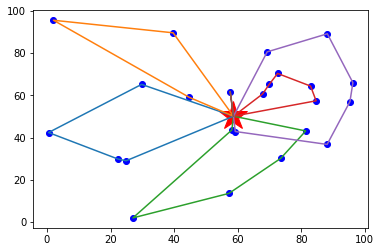

In [246]:
plt.plot(xc[0], yc[0], c = 'r', marker = '*', markersize=30)
plt.scatter(xc[1:], yc[1:],c = 'b')
for index, _ in enumerate(plot_x):
    plt.plot(plot_x[index], plot_y[index])

In [247]:
distances = {}
for index, value in enumerate(D.tolist()):
    distances[index+1] = value

In [248]:
best_c = execute_algorithm(genetic_problem_instances, need, lambda y: fitness(y), nG=500, nP = 300, pD = 0.6, pM=0.02)

num of trucks =  3
Capacity of trucks =  100

Chromosome:  [(1, 20), (4, 32), (6, 43), (7, 8), (17, 9), (9, 23), (12, 15), (14, 18), (18, 20), (2, 36), (3, 42), (20, 27), (16, 7), (13, 23), (5, 12), (19, 17), (8, 13), (22, 16), (23, 33), (25, 26), (24, 19), ('truck', 100), ('truck', 100), (10, 26), (21, 9), (11, 5), (15, 29)]
Solution:  (([(1, 'start'), (1, 20), (4, 32), (6, 43), (1, 'full'), (7, 8), (17, 9), (9, 23), (12, 15), (14, 18), (18, 20), (1, 'full'), (2, 36), (3, 42), (1, 'full'), (20, 27), (16, 7), (13, 23), (5, 12), (19, 17), (8, 13), (1, 'full'), (22, 16), (23, 33), (25, 26), (24, 19), (1, 'end'), ('truck', 100), (1, 'start'), (1, 'end'), ('truck', 100), (1, 'start'), (10, 26), (21, 9), (11, 5), (15, 29), (1, 'end')], [459, 0, 69]), 191)
7
Chromosome:  [(17, 9), (22, 16), (20, 27), (16, 7), (13, 23), (8, 13), (4, 32), (7, 8), (9, 23), (19, 17), (12, 15), (3, 42), (5, 12), (11, 5), (15, 29), (6, 43), (2, 36), (23, 33), (25, 26), (24, 19), ('truck', 100), ('truck', 100), (1,

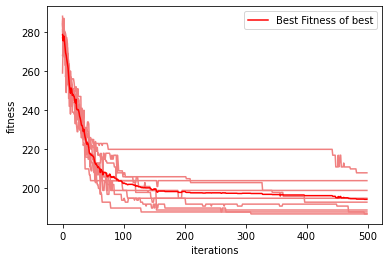

Variable: best		best	
Max Best Fitness		208	
Min Best Fitness		187	
Mean Best Fitness		194.4	
Max Poplution Fitness		214.0	
Min Poplution Fitness		195.0	
Mean Poplution Fitness		202.3	


In [249]:
comp_res([best_c],['best'])